<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Линейная-регрессия-с-регулязацией-L2" data-toc-modified-id="Линейная-регрессия-с-регулязацией-L2-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия с регулязацией L2</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для компании "Цифра", которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Для этого используются данные с параметрами добычи и очистки. Таким образом модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Эффективность обогащения рассчитывается по формуле:

`recovery = C * (F - T) / F * (C - T) `

где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки;

Описание данных
- Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

Предварительный план работы:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

In [55]:
RANDOM_STATE = 12345

In [56]:
try:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    print("Data load error")

Данные успешно загружены, сделаем их краткий первоначальный обзор с помощью `.head()` и `.info()`

In [57]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [58]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [59]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [60]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [61]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [62]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [63]:
df_full.shape

(19439, 87)

In [64]:
df_test.shape

(5290, 53)

In [65]:
df_train.shape

(14149, 87)

Как можно заметить, в данных всего 19439 наблюдений, из них 5290(\~27%) отнесли к тестовой выборке, а 14149 оставили для обучающей(\~73%). При этом у тестовой отсутствует 34 признака. В дальнейшем необходимо будет установить причину этого, но для начала проверим, правильно ли была рассчитана эффективность обогащения:

In [66]:
def get_recovery(c, f, t):
    return (c * (f - t)) / (f * (c - t)) * 100

In [67]:
#доля золота в концентрате;
c = df_train["rougher.output.concentrate_au"]
#доля золота в сырье
f = df_train["rougher.input.feed_au"]
#доля золота в отвальных хвостах
t = df_train["rougher.output.tail_au"]

mae = abs(df_train["rougher.output.recovery"] - get_recovery(c, f, t)).mean()
print("MAE для ффективности обогащения флотации:",mae)

MAE для ффективности обогащения флотации: 9.73512347450521e-15


Таким образом, среднее абсолютное отклонение достаточно мало, чтобы списать его на ошибку вычислений с плавающей точкой, а вычисленные нами и исходные значения можно назвать одинаковыми.

А это означает, что эффективность обогащения представлена корректно, а признаки соответствуют действительности.

Рассмотрим отличия в признаках между тестовой и другими выборками:

In [68]:
diff_columns = np.setdiff1d(df_train.columns.to_numpy(), df_test.columns.to_numpy())

In [69]:
print('\n'.join(diff_columns))

final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_au
secondary_cleaner.

Как можно заметить, для всех четырех этапов в тестовой выборке отсутствуют следующие признаки:
- коэффициент восстановления золота, который должна предсказывать модель (.output.recovery)
- доля веществ в концентрате после флотации/очистки(.output.concentrate_*)
- доля веществ в отвальных хвостах после флотации/очистки(.output.tail_*)

Отсутствуют и расчётные характеристики, которые раньше были у этапа флотации. (rougher.calculation.*)

Таким образом, помимо целевого признака отсутствуют необходимые признаки для рассчета эффективности обогащения по ранее использованной формуле. Нас это устраивает, т.к. часть этих величин мы будем прогнозировать, а остальные признаки скорее всего все равно пришлось бы убрать для избежания мультиколлинеарности.

Т.к. все эти столбцы отсутствуют в тестовой выборке,не имеет смысла оставлять их и в обучающей (кроме целевых rougher.output.recovery и final.output.recovery):

In [70]:
diff_columns = diff_columns[(diff_columns != "final.output.recovery") & (diff_columns != "rougher.output.recovery")]

In [71]:
df_train = df_train.drop(diff_columns, axis="columns")

Взглянем на пропуски по столбцам:

In [72]:
nan_columns_count = df_train.isna().sum()
nan_columns_count = nan_columns_count[nan_columns_count != 0].sort_values(ascending=False)

In [73]:
nan_columns_count.head(15)

rougher.state.floatbank10_e_air             436
rougher.input.floatbank11_xanthate          428
secondary_cleaner.state.floatbank2_a_air    217
rougher.input.feed_size                     144
rougher.input.feed_pb                       100
primary_cleaner.input.xanthate              100
rougher.input.feed_sol                       78
rougher.input.floatbank11_sulfate            36
primary_cleaner.input.depressant             32
rougher.input.floatbank10_sulfate            29
secondary_cleaner.state.floatbank2_b_air     21
primary_cleaner.input.sulfate                20
rougher.input.feed_rate                       8
rougher.input.floatbank10_xanthate            8
secondary_cleaner.state.floatbank4_a_air      6
dtype: int64

Больше всего пропусков наблюдается в признаках rougher.state.floatbank10_e_air и rougher.input.floatbank11_xanthate, которые похожи так же и по названию. После них число пропусков падает, но не сильно. 

Представим пропуски так же в процентном соотношении;

In [74]:
nan_columns_count.head(15) / df_train.shape[0] * 100

rougher.state.floatbank10_e_air             3.081490
rougher.input.floatbank11_xanthate          3.024949
secondary_cleaner.state.floatbank2_a_air    1.533677
rougher.input.feed_size                     1.017740
rougher.input.feed_pb                       0.706764
primary_cleaner.input.xanthate              0.706764
rougher.input.feed_sol                      0.551276
rougher.input.floatbank11_sulfate           0.254435
primary_cleaner.input.depressant            0.226164
rougher.input.floatbank10_sulfate           0.204961
secondary_cleaner.state.floatbank2_b_air    0.148420
primary_cleaner.input.sulfate               0.141353
rougher.input.feed_rate                     0.056541
rougher.input.floatbank10_xanthate          0.056541
secondary_cleaner.state.floatbank4_a_air    0.042406
dtype: float64

In [75]:
nan_columns_count[nan_columns_count < 144].sum() / df_train.shape[0] * 100

3.3924658986500815

Признаки со 100 и менее пропусками составляют меньше процента от всего датасета. В связи с этим их можно отбросить. В худшем случае, их удаление приведет к потере 3 процентов всех данных, что является приемлемым значением.

In [76]:
df_train.shape[0]

14149

In [77]:
df_train = df_train.dropna(subset=nan_columns_count[nan_columns_count < 144].index)

In [78]:
df_train.shape[0]

13805

In [79]:
(14149 - 13805) / 14149 * 100

2.4312672273658915

После удаления пропусков датасет уменьшился на 2.43%, что является допустимым значением.

Теперь взглянем на столбцы с большим количеством пропусков:

In [80]:
nan_columns_count = df_train.isna().sum()
nan_columns_count = nan_columns_count[nan_columns_count != 0].sort_values(ascending=False)

In [81]:
nan_columns_count

rougher.state.floatbank10_e_air             429
rougher.input.floatbank11_xanthate          369
secondary_cleaner.state.floatbank2_a_air    205
rougher.input.feed_size                     139
dtype: int64

Осталось 4 признака, 3 из которых связаны с этапом флотации. 

При этом rougher.input.feed_size используется при расчете ключевого показателя. Остальные признаки связаны с флотационными установками.

Можно было бы попытаться восстановить эти данные по значениям других признаков, но для этого не хватит одной формулы recovery и необходимы знания предметной области, а у эксперта спросить сейчас возможности нет.

Всегда можно заполнить пропуски медианными значениями, но для начала посмотрим на их динамику:

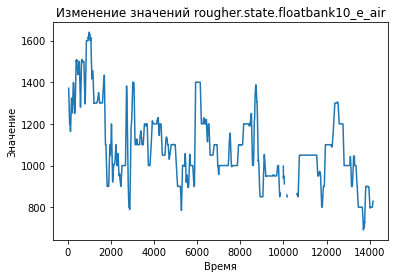

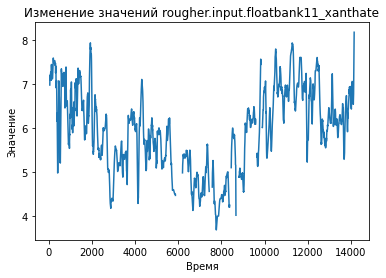

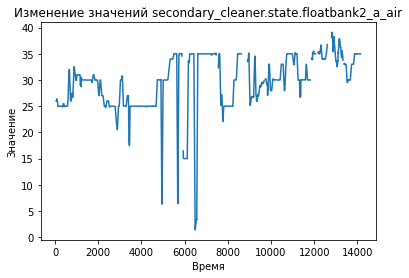

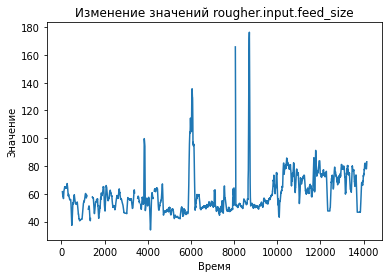

In [82]:
for col in nan_columns_count.index:
    df_train[col].rolling(50).mean().plot(title="Изменение значений " + col, xlabel="Время", ylabel="Значение")
    plt.show()

Как можно заметить, у признаков есть некая предсказуемая динамика(особенно у первых двух). Поэтому, вместо медианного значения, попробуем заполнить их средними от значений соседей с помощью скользящего окна. После этого останется малое количество пропусков, которые можно заполнить предыдущими значениями.

In [83]:
df_train = df_train.fillna(df_train.rolling(101, min_periods=1).mean())
df_train = df_train.fillna(method='bfill')

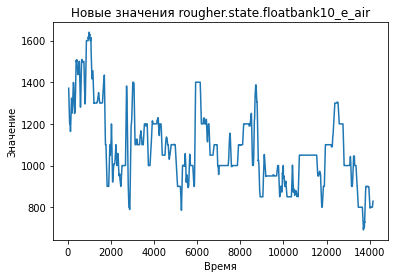

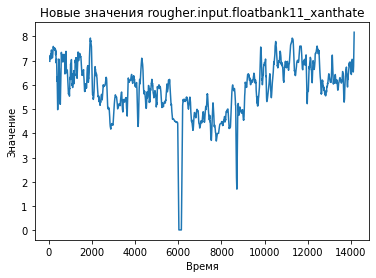

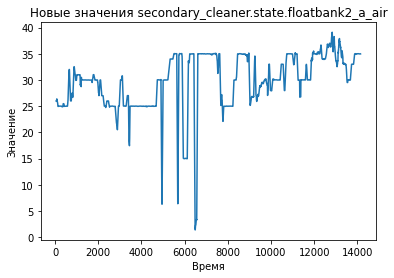

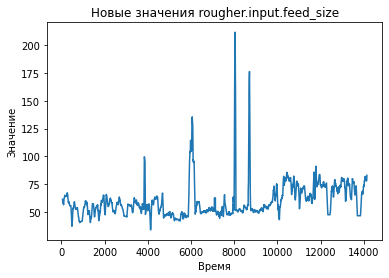

In [84]:
for col in nan_columns_count.index:
    df_train[col].rolling(50).mean().plot(title="Новые значения " + col, xlabel="Время", ylabel="Значение")
    plt.show()

После заполнения всех пропусков графики не сильно поменялись, а на некоторых появились пики, которые были бы упущены, если бы мы заполняли их медианными значениями по всему столбцу.

In [85]:
df_test.isna().sum().sort_values(ascending=False).head(20)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
secondary_cleaner.state.floatbank3_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
date                                           0
rougher.state.floatbank10_e_air                0
secondary_cleaner.state.floatbank3_b_air       0
dtype: int64

У тестовой выборки наблюдается малое количество пропусков (менее 2%), поэтому их можно отбросить.

In [86]:
df_test = df_test.dropna()

In [87]:
df_test.isna().sum().sort_values(ascending=False).head(5)

date                                 0
rougher.state.floatbank10_c_air      0
rougher.state.floatbank10_d_air      0
rougher.state.floatbank10_d_level    0
rougher.state.floatbank10_e_air      0
dtype: int64

Также проверим данные на дубликаты:

In [88]:
print(df_test.duplicated().sum())
print(df_train.duplicated().sum())

0
0


In [89]:
print(df_test['date'].duplicated().sum())
print(df_train['date'].duplicated().sum())

0
0


Как можно заметить, в данных нет явных дубликатов. Более того, у каждой строки в данных стоит новая дата, что тоже исключает возможные дубликаты.

Так же в тестовой выборке нет целевых признаков, которые пригодятся нам для подсчета метрик в заключительном этапе. Добавим два эти столбца в датасет:

In [90]:
df_test = df_test.merge(df_full[["date", "rougher.output.recovery", "final.output.recovery"]], how = 'left',
                left_on = 'date', right_on = 'date')

In [91]:
df_test[["rougher.output.recovery", "final.output.recovery"]].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

Целевые признаки успешно добавлены, а значит нам больше не пригодится столбец с датами для обучения или тестирования, т.к. он не влияет на целевой признак. Поэтому, удалим его из обучающей и тестовой выборки.

In [92]:
df_test = df_test.drop("date", axis="columns")
df_train = df_train.drop("date", axis="columns")

Для того чтобы модель лучше обучалась и имела перед собой более общую картину, стоит удалить из данных выбросы. 

Однако, перебирать 54 признака в ручную было бы слишком долго. Поэтому, удалим только совсем очевидные выбросы с помощью метода IQR, но вместо квартилей возьмем процентили 5 и 95:

In [93]:
for col in df_train.columns:
    Q1 = np.percentile(df_train[col], 5)
    Q3 = np.percentile(df_train[col],95)
    IQR = Q3 - Q1
    df_train = df_train.query("@Q1 - 1.5*@IQR < @df_train[@col] < @Q3 + 1.5*@IQR")

In [111]:
df_train.shape

(12493, 54)

Это было последней стадией предобработки данных и итоговый обучающий датасет на 11% меньше исходного, что ещё можно считать приемлимым значением потери данных.

В итоге, на данном этапе были успешно загружены данные, были отброшены лишние столбцы, которые не пригодятся в работе. Была проверена корректность рассчета целевой метрики для этапа флотации. Пропуски данных были заменены на значения с помощью скользящего окна или удалены, если их было малое количество. Так же в данных наблюдались выбросы, которые были удалены с помощью 5 и 95 процентиля.

## Анализ данных

Анализ данных начнем с того, что посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Начнем с концентрации золота:

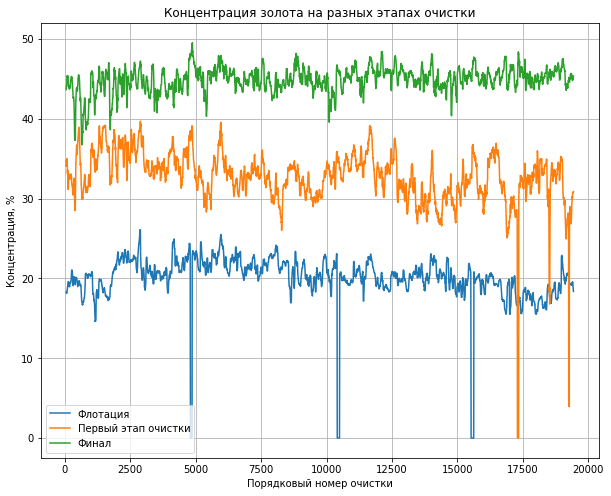

In [95]:
columns = ["rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]
ax = (
    df_full[columns]
    .rolling(50).median()
    .plot(grid=True, ylabel="Концентрация, %", xlabel="Порядковый номер очистки", 
          title="Концентрация золота на разных этапах очистки", figsize=(10, 8))
    
)
ax.legend(["Флотация", "Первый этап очистки", "Финал"]);

Графики показали ожидаемый результат. На начальном этапе флотации концентрация золота меньше всего (примерно \~20%). После следующего этапа она возрастает до \~35% и достигает макисимума в \~45% на финальном этапе. То есть, с каждым этапом концентрация золота возрастает и при этом больше всего это заметно между флотацией и первым этапом очистки.

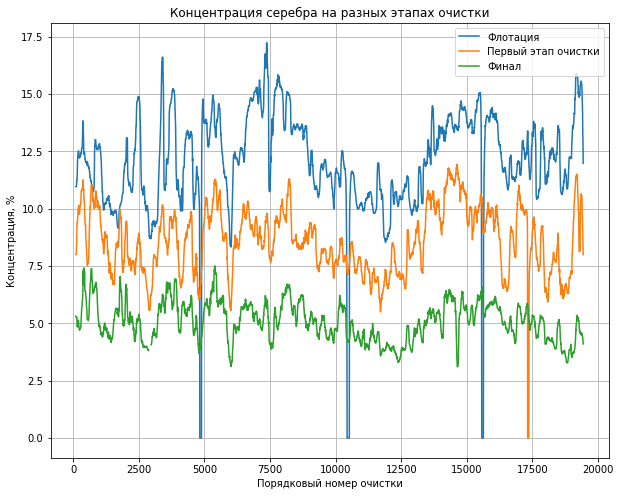

In [96]:
columns = ["rougher.output.concentrate_ag", "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag"]
ax = (
    df_full[columns]
    .rolling(100).median()
    .plot(grid=True, ylabel="Концентрация, %", xlabel="Порядковый номер очистки", 
          title="Концентрация серебра на разных этапах очистки", figsize=(10, 8))
    
)
ax.legend(["Флотация", "Первый этап очистки", "Финал"]);

Здесь динамика противоположна золоту, но все еще ожидаема. С каждым новым этапом концентрация становится все меньше, т.к. серебро в процессе должно отсеиваться от золота и уходить в отвальные хвосты. Однако, в финальном концентрате все ещё присутствует порядка 5% серебра. Стоит отметить так же небольшой размах концентрации серебра по сравнению с золотом. Здесь большинство значений укладывается в промежуток между 5 и 15 процентами.

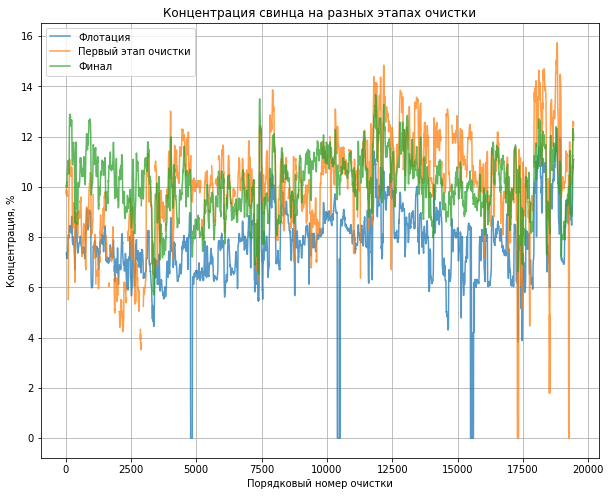

In [97]:
columns = ["rougher.output.concentrate_pb", "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb"]
ax = (
    df_full[columns]
    .rolling(30).median()
    .plot(grid=True, ylabel="Концентрация, %", xlabel="Порядковый номер очистки", 
          title="Концентрация свинца на разных этапах очистки", alpha=0.75, figsize=(10, 8))
    
)
ax.legend(["Флотация", "Первый этап очистки", "Финал"]);

Динамика концентрации свинца отличается от предыдущих. Здесь нет прямой зависимости от этапов, а иногда на последних двух концентрация свинца примерно одинаковая. Большинство значений при этом укладываются в промежуток от 6 до 12 процентов. Возможно, используемые реагенты не так эффективно отсеивают свинец или его отсеивание таким способом не выгодно с точки зрения производства. Для полного объяснения не хватает экспертных знаний.

Таким образом, наблюдается значительное повышение концентрации золота с каждым этапом. При этом, концентрация серебра уменьшается, а на свинец различные этапы производства влияют в малой степени.

Далее, сравним распределение размера гранул сырья на обучающей и тестовой выборках. Т. к. если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

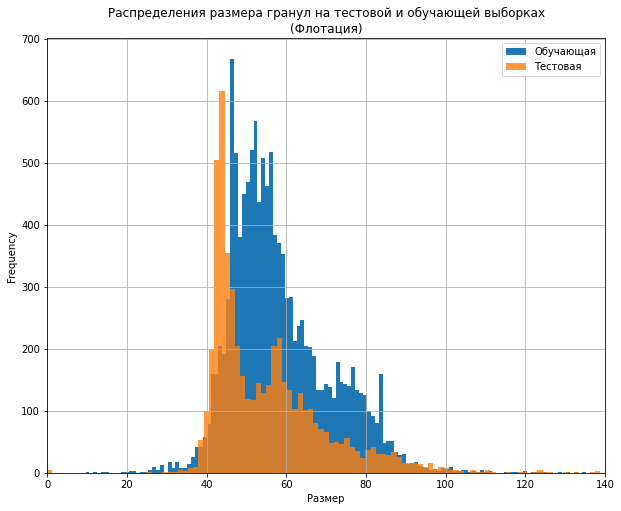

In [110]:
ax = df_train['rougher.input.feed_size'].plot(kind="hist",bins=140)
ax = df_test['rougher.input.feed_size'].plot(kind="hist", xlabel="Размер", bins=300, xlim=(0,140), figsize=(10, 8),
                                            title="Распределения размера гранул на тестовой и обучающей выборках\n(Флотация)",
                                            alpha=0.8, grid=True)
ax.set(xlabel="Размер")
ax.legend(["Обучающая", "Тестовая"]);

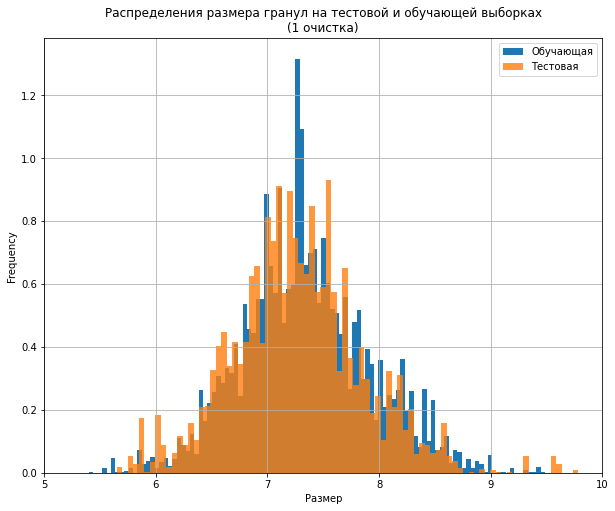

In [99]:
ax = df_train['primary_cleaner.input.feed_size'].plot(kind="hist",bins=140, density=True)
ax = df_test['primary_cleaner.input.feed_size'].plot(kind="hist", density=True, xlabel="Размер", bins=200, xlim=(5, 10), figsize=(10, 8),
                                            title="Распределения размера гранул на тестовой и обучающей выборках\n(1 очистка)",
                                            alpha=0.8, grid=True)
ax.set(xlabel="Размер")
ax.legend(["Обучающая", "Тестовая"]);

Из графиков видно, что распределения размеров гранул сильно схожи как для этапа очистки, так и для этапа флотации, что обеспечит корректность оценки модели.

Так же исследуем суммарную концентрацию веществ на уже рассмотренных ранее трех этапах:

Средняя суммарная концентрация для этапа rougher: 57.42559
Средняя суммарная концентрация для этапа rougher : 69.62651
Средняя суммарная концентрация для этапа final : 69.14050


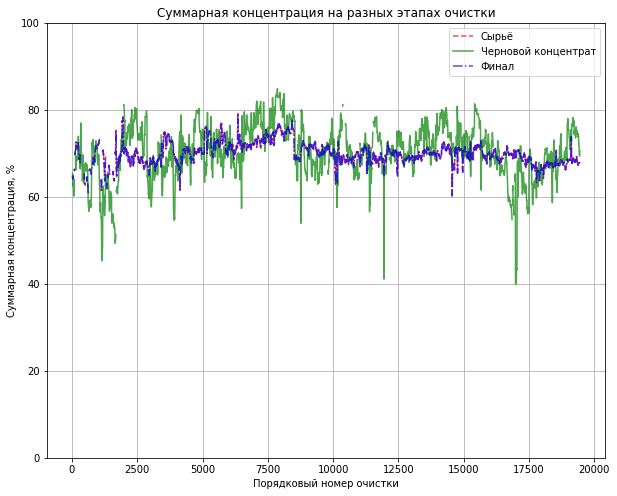

In [169]:
columns = [".output.concentrate_ag", ".output.concentrate_pb", 
           ".output.concentrate_sol", ".output.concentrate_au"]
columns_rougher = [".input.feed_pb", ".input.feed_sol", ".input.feed_au"]
concentrats = []

rougher_concentrat_sum = df_full["rougher.input.feed_ag"].copy()
rougher_concentrat_sum = rougher_concentrat_sum[rougher_concentrat_sum > 1]

for col in columns_rougher:
    rougher_concentrat_sum += df_full["rougher" + col]
    rougher_concentrat_sum = rougher_concentrat_sum[rougher_concentrat_sum > 1]
print(f"Средняя суммарная концентрация для этапа rougher: {rougher_concentrat_sum.mean():.5f}")
concentrats.append(stage_concentrat_sum)

for stage in ["rougher", "final"]:
    stage_concentrat_sum = df_full[stage + columns[0]].copy()
    stage_concentrat_sum = stage_concentrat_sum[stage_concentrat_sum > 1]
    for i in range(1, len(columns)):
        stage_concentrat_sum += df_full[stage + columns[i]]
    print(f"Средняя суммарная концентрация для этапа {stage} : {stage_concentrat_sum.mean():.5f}")
    concentrats.append(stage_concentrat_sum)

styles = ['r--','g-','b-.']
for i in range(len(concentrats)):
    ax = (
        concentrats[i]
        .rolling(20).median()
        .plot(grid=True, ylim=(0, 100), ylabel="Суммарная концентрация, %", xlabel="Порядковый номер очистки",
              title="Суммарная концентрация на разных этапах очистки", figsize=(10, 8), alpha=0.7, style=styles[i])

    )
ax.legend(["Сырьё", "Черновой концентрат", "Финал"])

Как можно заметить по графикам, у этапа сырья и финального концентрата примерно одинаковая суммарная концентрация, их графики почти накладываются друг на друга. Черновой вариант тоже близок к данной концентрации. Это означает, что суммарная концентрация, в отличии от концентрации определенных веществ, остается одной и той же на этапах производства.

В итоге, на этапе анализа было исследовано изменение концентрации веществ на каждом этапе очистки (как каждого вещества так и их суммарной концентрации). При чем при исследовании было установлено, что с каждым этапом концентрация золота увеличивается, и больше всего это происходит после флотации. Суммарная же концентрация не сильно меняется. Так же было исследовано распределение размера гранул на обучающей и тестовой выборке. Распределения не сильно отличались друг от друга.

## Модель

Перед тем как приступить к обучению модели, напишем функцию для вычисления итоговой sMAPE и разобъем обучающую выборку на обычные признаки и целевые:

In [101]:
def smape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) / ((np.abs(y_pred) + np.abs(y_true)) / 2)) * 100 / y_true.shape[0]

def smape_total(y_true, y_pred):
    smape_scores = smape(y_true, y_pred)
    return 0.25 * smape_scores["rougher.output.recovery"] + 0.75 * smape_scores["final.output.recovery"] 

smape_total_scorer = make_scorer(smape_total, greater_is_better=False)

In [102]:
X = df_train.drop(["rougher.output.recovery", "final.output.recovery"], axis="columns")
y = df_train[["rougher.output.recovery", "final.output.recovery"]]

Во время обучения будем использовать кроссвалидацию и следующие типы моделей:
- Дерево решений (DecisionTreeRegressor)
- Случайный лес (RandomForestRegressor)
- Линейная регрессия (LinearRegression)
- Линейная регрессия с регулязацией L2(Ridge)
- Градиентный бустинг (GradientBoostingRegressor)

### Дерево решений

In [104]:
best_result = (0, 100)
for depth in range(2, 15):
    model = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=10, scoring=smape_total_scorer)
    scores_mean = scores.mean()
    if abs(scores_mean) < abs(best_result[1]):
        best_result = (depth, scores_mean)
    print(f"Максимальная глубина: {depth} sMAPE: {scores_mean:.5f}")
print(f"Лучший результат:\n\tМаксимальная глубина: {best_result[0]} sMAPE: {best_result[1]:.5f}")

Максимальная глубина: 2 sMAPE: -8.05571
Максимальная глубина: 3 sMAPE: -7.83525
Максимальная глубина: 4 sMAPE: -7.73685
Максимальная глубина: 5 sMAPE: -8.09778
Максимальная глубина: 6 sMAPE: -8.47439
Максимальная глубина: 7 sMAPE: -8.97637
Максимальная глубина: 8 sMAPE: -10.41992
Максимальная глубина: 9 sMAPE: -11.48304
Максимальная глубина: 10 sMAPE: -11.21468
Максимальная глубина: 11 sMAPE: -11.33206
Максимальная глубина: 12 sMAPE: -11.89688
Максимальная глубина: 13 sMAPE: -13.07912
Максимальная глубина: 14 sMAPE: -12.32010
Лучший результат:
	Максимальная глубина: 4 sMAPE: -7.73685


Для дерева решений лучший результат sMAPE был равен -7.73 % при самой максимальной глубине дерева 4.

### Случайный лес

In [50]:
for est_amount in range(10, 51, 10):
    print(f"Estimators = {est_amount:<2d}:\t")
    
    for depth in range(4, 10):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est_amount, random_state=RANDOM_STATE)
        scores = cross_val_score(model, X, y, cv=10, scoring=smape_total_scorer)
            
        print(f"\tmax depth={depth:<2d} sMAPE: {scores.mean():.5f}")
    print()

Estimators = 10:	
	max depth=4  sMAPE: -7.540697944544041
	max depth=5  sMAPE: -7.438639886115799
	max depth=6  sMAPE: -7.542985562074238
	max depth=7  sMAPE: -7.634167422499449
	max depth=8  sMAPE: -7.695157315048403
	max depth=9  sMAPE: -7.77002624252886

Estimators = 20:	
	max depth=4  sMAPE: -7.504806451112115
	max depth=5  sMAPE: -7.402025626199507
	max depth=6  sMAPE: -7.455274939722254
	max depth=7  sMAPE: -7.538877262977546
	max depth=8  sMAPE: -7.5356861256197165
	max depth=9  sMAPE: -7.602207857679782

Estimators = 30:	
	max depth=4  sMAPE: -7.460102273772128
	max depth=5  sMAPE: -7.388909349755205
	max depth=6  sMAPE: -7.431855915233112
	max depth=7  sMAPE: -7.507064752625498
	max depth=8  sMAPE: -7.512236195743386
	max depth=9  sMAPE: -7.5575602400695105

Estimators = 40:	
	max depth=4  sMAPE: -7.466422769889978
	max depth=5  sMAPE: -7.398730680396797
	max depth=6  sMAPE: -7.434666888718349
	max depth=7  sMAPE: -7.486848353524053
	max depth=8  sMAPE: -7.4569072653558806
	ma

Для модели случайного леса результат немного лучше: -7.389% при 30 оценщиках и максимальной глубине 5.

### Линейная регрессия 

In [51]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=10, scoring=smape_total_scorer)
print(f"Средний sMAPE для линейной регрессии: {scores.mean():.5f}")

Средний sMAPE для линейной регрессии: -8.229749463936253


Линейная регрессия показала метрику -8.23%, что хуже чем остальные результаты.

### Линейная регрессия с регулязацией L2

In [55]:
for alpha in np.arange(0.1, 1.1, 0.1):
    model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=10, scoring=smape_total_scorer)
    print(f"Альфа: {alpha:.1f} sMAPE: {scores.mean():.5f}")

Альфа: 0.1 sMAPE: -8.22973
Альфа: 0.2 sMAPE: -8.22970
Альфа: 0.3 sMAPE: -8.22968
Альфа: 0.4 sMAPE: -8.22966
Альфа: 0.5 sMAPE: -8.22964
Альфа: 0.6 sMAPE: -8.22962
Альфа: 0.7 sMAPE: -8.22959
Альфа: 0.8 sMAPE: -8.22957
Альфа: 0.9 sMAPE: -8.22955
Альфа: 1.0 sMAPE: -8.22953


Добавление регулязации к линейной регрессии так же не показало улучшений метрики, здесь значения так же примерно -8.23%.

### Градиентный бустинг

In [66]:
for est_amount in range(10, 41, 10):
    print(f"Estimators = {est_amount:<2d}:\t")
    
    for depth in range(4, 9):
        params = {'n_estimators': est_amount, 'max_depth': depth, 'random_state' : RANDOM_STATE}

        model = MultiOutputRegressor(GradientBoostingRegressor(**params))
        scores = cross_val_score(model, X, y, cv=10, scoring=smape_total_scorer)
            
        print(f"\tmax depth={depth:<2d} sMAPE: {scores.mean():.5f}")
    print()

Estimators = 10:	
	max depth=4  sMAPE: -7.68164
	max depth=5  sMAPE: -7.73830
	max depth=6  sMAPE: -7.77188
	max depth=7  sMAPE: -7.83589
	max depth=8  sMAPE: -7.93240

Estimators = 20:	
	max depth=4  sMAPE: -7.46841
	max depth=5  sMAPE: -7.55897
	max depth=6  sMAPE: -7.66099
	max depth=7  sMAPE: -7.82854
	max depth=8  sMAPE: -7.93130

Estimators = 30:	
	max depth=4  sMAPE: -7.46425
	max depth=5  sMAPE: -7.64104
	max depth=6  sMAPE: -7.68191
	max depth=7  sMAPE: -7.94184
	max depth=8  sMAPE: -8.01122

Estimators = 40:	
	max depth=4  sMAPE: -7.56444
	max depth=5  sMAPE: -7.74428
	max depth=6  sMAPE: -7.71931
	max depth=7  sMAPE: -7.95622
	max depth=8  sMAPE: -8.04052



Лучший результат градиентного бустинга это -7.464 %, что все ещё хуже чем у случайного леса.

В результате обучения моделей не было замечено сильных различий в sMAPE. Значения колебались в пределах -7.3 и -8.2 процентов. Однако, лучший результат в -7.73 % показала модель случайного леса при 30 оценщиках и максимальной глубине 5. Именно её мы и будем проверять на тестовой выборке в следующем этапе.

## Тестирование лучшей модели

Сформируем данные для обучения и тестирования:

In [170]:
X_train = df_train.drop(["rougher.output.recovery", "final.output.recovery"], axis="columns")
y_train = df_train[["rougher.output.recovery", "final.output.recovery"]]
X_test = df_test.drop(["rougher.output.recovery", "final.output.recovery"], axis="columns")
y_test = df_test[["rougher.output.recovery", "final.output.recovery"]]

Обучим лучшую модель:

In [171]:
model = RandomForestRegressor(max_depth=5, n_estimators=30, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=30, random_state=12345)

И протестируем её:

In [172]:
smape_total_scorer(model, X_test, y_test)

-10.033432831925818

Показатель тестовой выборки хуже на 2 процента, что кажется приемлимым итоговым значением. Но для большей уверености стоит проверить результат на адекватность с помощью фиктивной модели. 

Однако, вместо заполнения фиктивной модели медианами заполним её случайными числами от 0 до 100.
Это связано с тем, что у тестовой выборки крайне низка дисперсия, и использование такой модели в данном случае не совсем корректно.

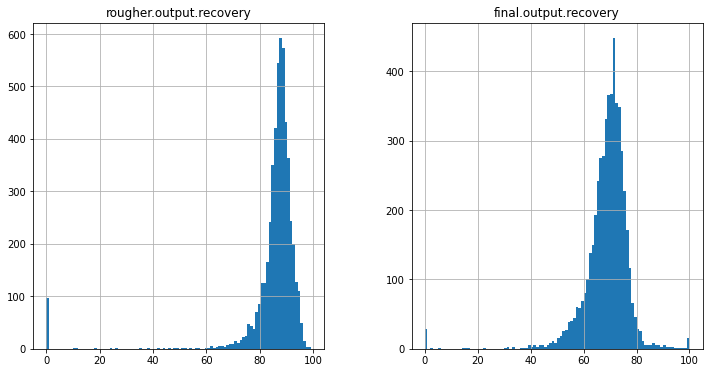

In [173]:
y_test.hist(bins=100, figsize=(12, 6))
None

In [174]:
y_test.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,rougher.output.recovery,final.output.recovery
count,5229.000000,5229.000000
mean,85.132232,68.657602
std,12.932195,8.837928
min,0.000000,0.000000
10%,79.982371,60.185346
25%,84.616732,65.598158
50%,87.423038,69.857034
75%,89.749360,73.294055
90%,92.139854,76.086416
max,99.169699,100.000000


In [175]:
(abs(79 - 87) / ((78 + 87) / 2)) * 100 / 2

4.848484848484849

Как можно заметить, если взять за предсказание медиану, то 80 % случаев будут иметь отклонение sMAPE менее 5%, что уже даст результаты, близкие к идеальным. В связи с этим, данная фиктивная модель нам не подходит.

Предсказания фиктивной модели по медиане:

In [176]:
fake_predictions = np.array([[y_train["rougher.output.recovery"].median(), 
                              y_train["final.output.recovery"].median()]] * y_test.shape[0])

In [177]:
smape_total(fake_predictions, y_test)

8.9478742059162

Поэтому возьмем для данной задачи массивы случайных чисел:

In [234]:
fake_predictions = np.random.rand(y_test.shape[0], 2) * 100

In [235]:
smape_total(fake_predictions, y_test)

63.0353295529826

Здесь процентное отклонение гораздо больше, а это значит, что наша модель лучше случайной, и она прошла эту проверку на адекватность.

## Итоговый вывод

В результате работы были успешно загружены и обозрены данные об обработке золотой руды.

Правильность данных была проверена повторным рассчетом признака обогащения, так же были удалены признаки, которые не понадобились для обучения модели. Была проведена предобработка данных, в ходе которой данные были очищены от выбросов и пропусков.

Во время анализа данных были исследованы значения концентраций веществ на разных этапах производства. Было обнаружено, что концентрация золота существенно повышается после этапа флотации, а концентрация серебера, наоборот, падает. Были рассмотрены распределения гранул сырья на обучающей и тестовой выборках. Распределения не сильно отличались друг от друга.

Во время работы были обучены 5 типов моделей, но лучшие результаты показал случайный лес (sMAPE = -7.389%). Следующей по показателям метрик является модель градиентного бустинга (sMAPE = -7.464%).

Финальное тестирование модели случайного леса показало относительно низкую метрику симметричного среднего абсолютного процентного отклонения в \~-10%, что говорит о хорошей предсказательной способности модели.